# CS231: Computer Vision 
## Final Project: Traffic sign classification ##


# Import Libraries #

In [57]:
import os
import warnings
import random
import numpy as np 
import pandas as pd 
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import pickle

# Data Loading #

In [58]:
base_dir = "./data/traffic_Data/"
train_dir = base_dir + "/DATA/"
class_dirs = ["3", "5", "11", "16", "24", "26", "28", "30", "54", "55"]

In [59]:
image_paths = []
for cls in class_dirs:
    for file_name in os.listdir(train_dir+cls):
        if file_name.split('.')[-1] == 'png':
            image_paths.append(os.path.join(train_dir, cls, file_name))

print("Total image =", len(image_paths))

Total image = 1375


In [60]:
classes = []

for image_path in image_paths:
    image_path = image_path.replace("\\","/")
    classes.append(image_path.split('/')[-2])

In [61]:
print(classes)

['3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5',

# Data Preprocessing #

In [62]:
img_ls = []
for i in image_paths:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img_ls.append(img)

In [63]:
le = LabelEncoder()
y_train = le.fit_transform(classes)
y_train = np.array(y_train)
print(y_train)

[5 5 5 ... 9 9 9]


In [64]:
unique_classes = np.unique(y_train)
print(unique_classes)
class_indices = {class_id: np.where(y_train == class_id)[0] for class_id in unique_classes}
print(class_indices[2])

[0 1 2 3 4 5 6 7 8 9]
[557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610
 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628
 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656]


['Dont Go Left', 'No Car', 'Go Right', 'keep Right', 'watch out for cars', 'Speed limit (40km/h)', 'Bicycles crossing', 'Speed limit (60km/h)', 'No stopping', 'No entry']


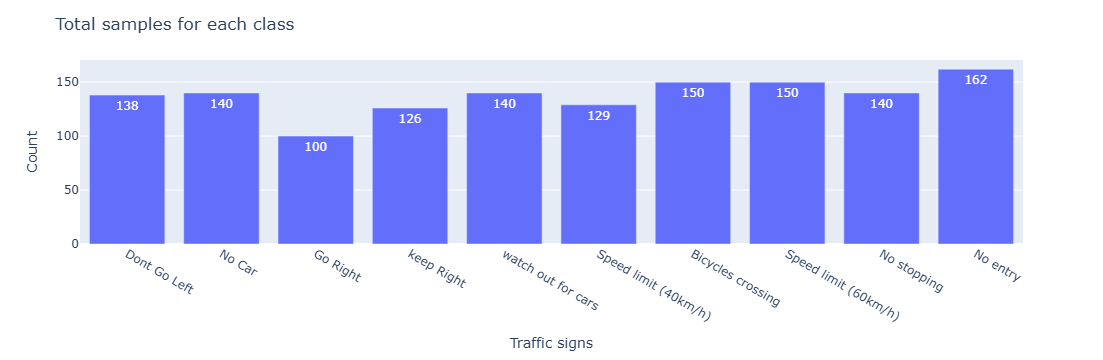

In [34]:
# ploting total samples for each class
labels = pd.read_csv('./data/labels.csv')

class_names = []

class_id = le.inverse_transform(unique_classes)
for i in class_id:
    class_name = labels.loc[labels["ClassId"] == int(i), "Name"].iloc[0]
    class_names.append(class_name)
print(class_names)
images_count = [len(class_indices[key]) for key in class_indices.keys()]

fig = px.bar(x=class_names, y=images_count)

fig.update_layout(xaxis_title='Traffic signs', yaxis_title='Count', title="Total samples for each class", )
fig.update_traces(texttemplate='%{y}', textposition='inside')
# fig.write_image("./figs/classes_bar.png")
fig.show()

Displaying sample images for each class randomly.

In [65]:
def plotSample(img_ls):
    plt.figure(figsize=(12, 5))
    for i, (class_id, indices) in enumerate(class_indices.items()):
        random_index = np.random.choice(indices)
        random_image = img_ls[random_index].astype(np.uint8) 
        plt.subplot(1, len(unique_classes), i + 1)
        plt.imshow(random_image)
        plt.title(class_names[class_id], fontdict={'fontsize': 8})
        plt.axis('off')
    plt.tight_layout()
    # plt.savefig("figs/segmented_class_samples")
    plt.show()

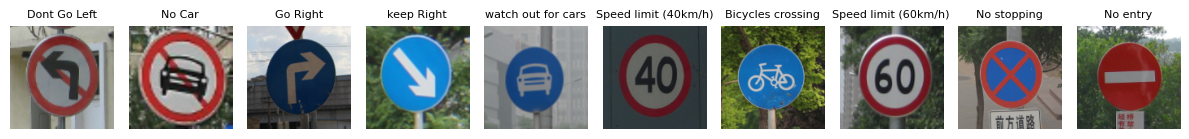

In [66]:
plotSample(img_ls)

# Feature Extraction #


Remove background using opencv's GrabCut

In [67]:
def graphSeg(img, x, y, w, h):
  mask = np.zeros(img.shape[:2], np.uint8)
  backgroundModel = np.zeros((1, 65), np.float64)
  foregroundModel = np.zeros((1, 65), np.float64)
  rectangle = (x, y, w, h)
  cv2.grabCut(img, mask, rectangle,backgroundModel,foregroundModel,5, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  img = img * mask2[:, :, np.newaxis]
  return img

In [13]:
for i in range(len(img_ls)):
  img_ls[i] = graphSeg(img_ls[i],5,5,118,118)

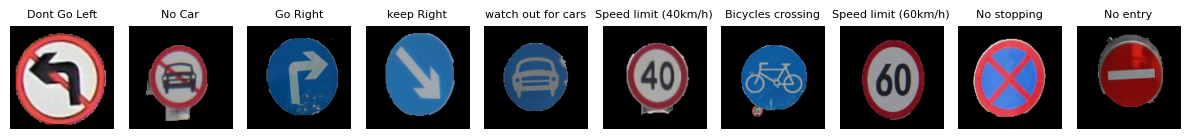

In [14]:
plotSample(img_ls)

## Histogram ##


In [38]:
hist_features_ls = np.zeros(shape=(len(img_ls), 3, 255, 1))

In [68]:
def calcAllHist(img):
    hist_features = np.zeros(shape=(3,255, 1))
    r_hist = cv2.calcHist([img], [0], None, [255], [1, 256])
    g_hist = cv2.calcHist([img], [1], None, [255], [1, 256])
    b_hist = cv2.calcHist([img], [2], None, [255], [1, 256])
    r_hist, g_hist, b_hist = r_hist/r_hist.sum(), g_hist/g_hist.sum(), b_hist/b_hist.sum()
    hist_features[0] = r_hist
    hist_features[1] = g_hist
    hist_features[2] = b_hist
    return hist_features

In [17]:
for i, img in enumerate(img_ls):
    hist_features_ls[i] = calcAllHist(img)

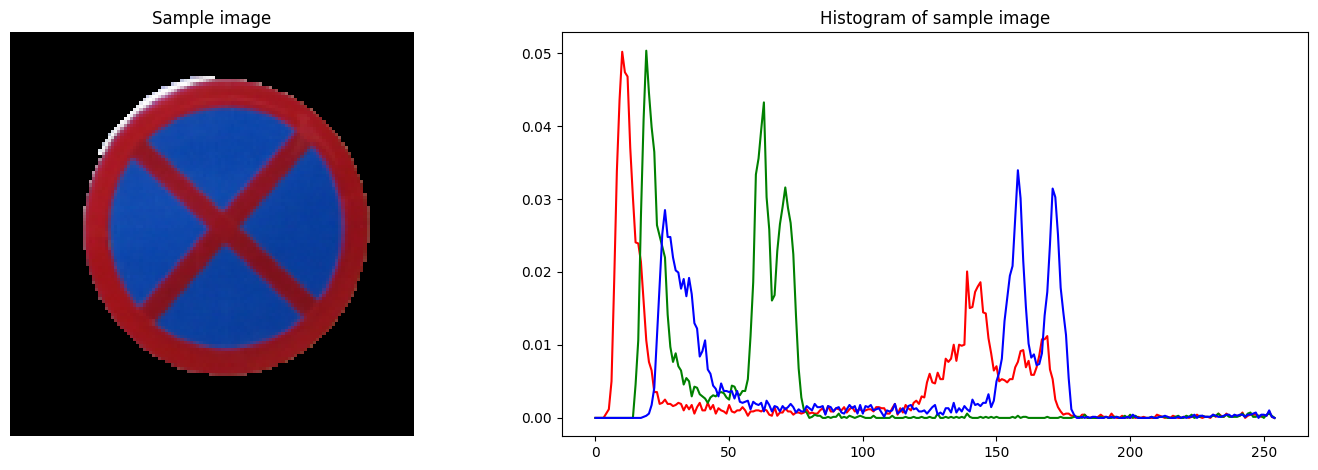

In [18]:
rand_index = random.randrange(0, len(img_ls), 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.plot(hist_features_ls[rand_index][0], color="red")
ax2.plot(hist_features_ls[rand_index][1], color ="green")
ax2.plot(hist_features_ls[rand_index][2], color="blue")
ax2.title.set_text("Histogram of sample image")
fig.tight_layout()
fig.savefig("./figs/histogram")


## Canny filter ##

In [40]:
canny = np.zeros(shape=(len(img_ls), 128, 128))
canny_features_ls = np.zeros(shape=(len(img_ls), 256))

In [69]:
def cannyFilter(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filtered_img = cv2.Canny(gray_img, 100, 200)
    filtered_img = filtered_img/256

    feature = []
    for i in range(filtered_img.shape[0]):
        feature.append(np.sum(filtered_img[i, :]))
    # Sum of edge values in each column
    for j in range(filtered_img.shape[1]):
        feature.append(np.sum(filtered_img[:, j]))
    return filtered_img,feature

In [21]:
for i, img in enumerate(img_ls):
    canny[i],canny_features_ls[i] = cannyFilter(img)


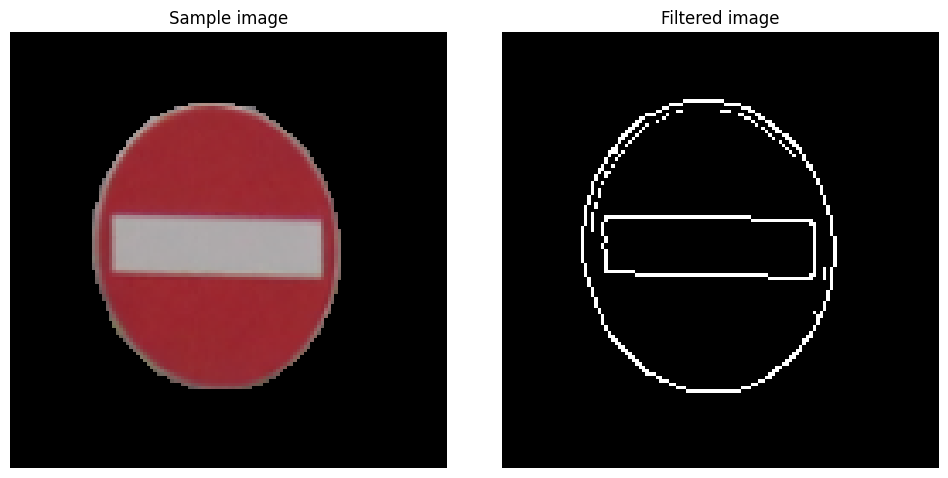

In [22]:
rand_index = random.randrange(0, len(img_ls), 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.imshow(canny[rand_index], cmap='gray')
ax2.axis("off")
ax2.title.set_text("Filtered image")
fig.tight_layout()
fig.savefig("./figs/canny")

## HOG ##


In [42]:
hog_features_ls = np.zeros(shape=(len(img_ls), 34596))

In [70]:
def computeHOG(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  hog_feature = hog(gray_img, orientations=9,
                                pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                                block_norm='L2-Hys', transform_sqrt=True)
  return hog_feature

In [17]:
for i, img in enumerate(img_ls):
    hog_features_ls[i] = computeHOG(img)

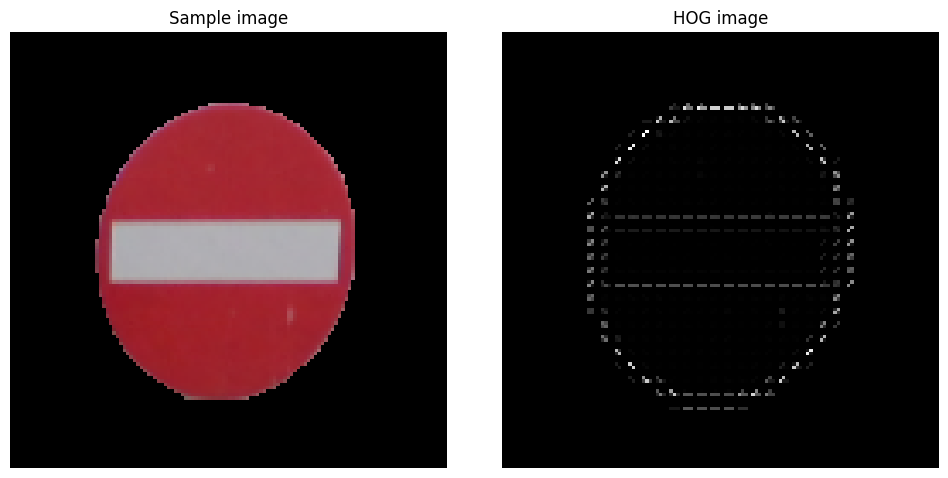

In [18]:
rand_index = random.randrange(0, len(img_ls), 1)
gray_img = cv2.cvtColor(img_ls[rand_index], cv2.COLOR_RGB2GRAY)
hog_feature, hog_image = hog(gray_img, orientations=9,
                                pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                                block_norm='L2-Hys', visualize=True, transform_sqrt=True)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.imshow(hog_image, cmap='gray')
ax2.axis("off")
ax2.title.set_text("HOG image")
fig.tight_layout()
fig.savefig("./figs/HOG")

# ML Model Training #

In [44]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [45]:
cv = RepeatedStratifiedKFold(n_splits=5)

In [46]:
n_neighbors = range(1, 21, 1)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid_knn = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=grid_knn, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [47]:
n_estimators = [1, 10, 100, 1000]
max_depth = [int(x) for x in np.linspace(10, 100, num = 6)]
max_features = ['sqrt', 'log2']
grid_rf = dict(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=grid_rf, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

### Histogram ###

In [31]:
X_train_hist_flattened = hist_features_ls.reshape(hist_features_ls.shape[0], -1)
print("Flattened data = ", X_train_hist_flattened.shape,  y_train.shape)

Flattened data =  (1375, 765) (1375,)


#### KNN with histogram


In [40]:
grid_knn_result_hist = grid_search_knn.fit(X_train_hist_flattened, y_train)

In [41]:
print("Best: %f using %s" % (grid_knn_result_hist.best_score_, grid_knn_result_hist.best_params_))
means = grid_knn_result_hist.cv_results_['mean_test_score']
stds = grid_knn_result_hist.cv_results_['std_test_score']
params = grid_knn_result_hist.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937818 using {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
0.918400 (0.018126) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.918400 (0.018126) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.810545 (0.016967) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.918400 (0.018126) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.774109 (0.020719) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.904000 (0.016885) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.730327 (0.025344) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.900218 (0.016981) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.723127 (0.027134) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.893673 (0.020500) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.683127 (

In [42]:
joblib.dump(grid_knn_result_hist.best_estimator_, "./models/best_knn_hist.pkl", compress = 3)

['./models/best_knn_hist.pkl']

#### Random Forest with histogram

In [32]:
grid_rf_result_hist = grid_search_rf.fit(X_train_hist_flattened, y_train)

In [33]:
print("Best: %f using %s" % (grid_rf_result_hist.best_score_, grid_rf_result_hist.best_params_))
means = grid_rf_result_hist.cv_results_['mean_test_score']
stds = grid_rf_result_hist.cv_results_['std_test_score']
params = grid_rf_result_hist.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.936509 using {'max_depth': 64, 'max_features': 'log2', 'n_estimators': 100}
0.759855 (0.033761) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1}
0.905455 (0.022709) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.927345 (0.018492) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.928218 (0.019239) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.740945 (0.033173) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1}
0.904582 (0.019318) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.930400 (0.020403) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.930764 (0.018712) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
0.796000 (0.028505) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 1}
0.918473 (0.016084) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 10}
0.933455 (0.017458) with: {'max_d

In [34]:
joblib.dump(grid_rf_result_hist.best_estimator_, "./models/best_rf_hist.pkl", compress = 3)

['./models/best_rf_hist.pkl']

### Canny

In [36]:
X_canny_flattened = canny_features_ls.reshape(canny_features_ls.shape[0], -1)

print("Flattened data = ", X_canny_flattened.shape,  y_train.shape)

Flattened data =  (1375, 256) (1375,)


#### KNN with Canny

In [37]:
grid_knn_result_canny = grid_search_knn.fit(X_canny_flattened, y_train)

In [38]:
print("Best: %f using %s" % (grid_knn_result_canny.best_score_, grid_knn_result_canny.best_params_))
means = grid_knn_result_canny.cv_results_['mean_test_score']
stds = grid_knn_result_canny.cv_results_['std_test_score']
params = grid_knn_result_canny.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.970327 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
0.948364 (0.012618) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.948364 (0.012618) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.907636 (0.017056) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.948364 (0.012618) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.860436 (0.019956) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.945236 (0.012977) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.860436 (0.019158) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.945018 (0.013443) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.856218 (0.017397) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.943782 (0.013055) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.849891 

In [39]:
joblib.dump(grid_knn_result_canny.best_estimator_, "./models/best_knn_canny.pkl", compress = 3)

['./models/best_knn_canny.pkl']

#### Random Forest wit Canny

In [40]:
grid_rf_result_canny = grid_search_rf.fit(X_canny_flattened, y_train)

In [41]:
print("Best: %f using %s" % (grid_rf_result_canny.best_score_, grid_rf_result_canny.best_params_))
means = grid_rf_result_canny.cv_results_['mean_test_score']
stds = grid_rf_result_canny.cv_results_['std_test_score']
params = grid_rf_result_canny.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.981382 using {'max_depth': 82, 'max_features': 'log2', 'n_estimators': 1000}
0.818618 (0.027004) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1}
0.956873 (0.011951) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.975636 (0.010571) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.977455 (0.010933) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.807418 (0.033144) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1}
0.956945 (0.011134) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.976364 (0.010988) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.979564 (0.010359) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
0.845455 (0.026325) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 1}
0.960582 (0.014461) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 10}
0.978255 (0.009356) with: {'max_

In [42]:
joblib.dump(grid_rf_result_canny.best_estimator_, "./models/best_rf_canny.pkl", compress = 3)

['./models/best_rf_canny.pkl']

### HOG

In [23]:
X_hog_flattened = hog_features_ls
print("Flattened data = ", X_hog_flattened.shape,  y_train.shape)

Flattened data =  (1375, 34596) (1375,)


#### KNN with HOG

In [44]:
grid_knn_result_hog = grid_search_knn.fit(X_hog_flattened, y_train)

In [45]:
print("Best: %f using %s" % (grid_knn_result_hog.best_score_, grid_knn_result_hog.best_params_))
means = grid_knn_result_hog.cv_results_['mean_test_score']
stds = grid_knn_result_hog.cv_results_['std_test_score']
params = grid_knn_result_hog.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.985164 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.985164 (0.009195) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.985164 (0.009195) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.969964 (0.010072) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.985164 (0.009195) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.958691 (0.010830) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.980218 (0.009950) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.955491 (0.012116) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.982109 (0.009807) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.956800 (0.012377) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.979855 (0.009790) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.954618 (

In [46]:
joblib.dump(grid_knn_result_hog.best_estimator_, "./models/best_knn_hog.pkl", compress = 3)

['./models/best_knn_hog.pkl']

#### Random Forest with HOG

In [25]:
grid_rf_result_hog = grid_search_rf.fit(X_hog_flattened, y_train)

In [26]:
print("Best: %f using %s" % (grid_rf_result_hog.best_score_, grid_rf_result_hog.best_params_))
means = grid_rf_result_hog.cv_results_['mean_test_score']
stds = grid_rf_result_hog.cv_results_['std_test_score']
params = grid_rf_result_hog.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999273 using {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000}
0.833745 (0.034011) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1}
0.985164 (0.009366) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.997745 (0.003841) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.999200 (0.002444) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.722109 (0.043679) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1}
0.959273 (0.014065) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.994982 (0.005581) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.998400 (0.003183) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
0.859418 (0.021023) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 1}
0.984073 (0.009563) with: {'max_depth': 28, 'max_features': 'sqrt', 'n_estimators': 10}
0.998109 (0.003020) with: {'max

In [27]:
joblib.dump(grid_rf_result_hog.best_estimator_, "./models/best_rf_hog.pkl", compress = 3)

['./models/best_rf_hog.pkl']

# Model Evaluation #

## Load test set

In [89]:
test_dir = base_dir + "TEST/"
test_img = []
y_test = []
test_img_paths = []
for file_name in os.listdir(test_dir):
    # print(file_name)
    img_path = os.path.join(test_dir, file_name)
    test_img_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    test_img.append(img)
    y_test.append(file_name.split("_")[0].lstrip('0'))
y_test = le.transform(y_test)
print("Total test images: ", len(test_img))
print(y_test)

Total test images:  379
[2 7 7 7 8 1 1 5 3 0 3 0 8 0 6 0 4 6 9 3 6 7 9 8 8 5 6 9 3 6 3 8 4 9 3 8 7
 7 4 9 2 8 3 6 8 4 1 2 6 7 9 3 0 2 5 0 1 0 7 8 8 3 6 0 2 6 8 5 7 6 3 2 7 0
 1 5 8 1 6 1 8 9 3 5 1 9 2 0 4 1 9 8 8 4 3 1 1 7 4 3 3 9 4 8 4 4 0 8 8 6 1
 6 4 5 6 4 8 0 1 7 7 3 0 3 1 7 1 7 5 1 3 2 9 2 8 3 8 4 4 3 8 7 3 9 3 9 2 1
 0 8 9 3 4 6 9 5 3 8 3 9 4 8 7 9 4 3 2 3 9 6 8 4 0 9 4 4 3 3 8 4 2 0 9 3 0
 4 9 0 4 3 5 7 7 4 0 2 2 8 0 3 5 0 7 0 6 5 5 1 0 9 4 1 7 1 7 6 5 0 2 5 9 1
 5 6 1 8 4 3 0 3 0 5 1 9 7 6 1 1 7 8 4 9 7 0 1 4 2 5 8 6 3 7 5 6 5 7 9 3 1
 9 4 5 8 8 7 0 5 0 0 7 5 1 8 5 6 0 0 8 3 4 3 8 9 5 6 4 7 5 7 6 8 6 8 0 0 2
 4 3 1 9 5 2 8 5 1 2 6 7 0 5 5 7 9 1 9 3 3 5 4 7 3 3 5 9 7 1 1 6 3 8 4 8 1
 7 1 8 9 3 4 8 4 8 9 9 9 2 6 9 8 5 5 6 1 8 1 0 9 3 5 0 9 1 0 6 1 4 6 1 3 2
 4 9 2 0 6 2 4 4 6]


In [103]:
# ploting total samples for each class
labels = pd.read_csv('./data/labels.csv')

class_names = []

class_id = le.inverse_transform(unique_classes)
print(class_id)
for i in class_id:
    class_name = labels.loc[labels["ClassId"] == int(i), "Name"].iloc[0]
    class_names.append(class_name)

class_ids = []
for test_img_path in test_img_paths:
    class_ids.append(test_img_path.split("/")[-1].split("_")[0].lstrip("0"))

test_class_indices = {class_id: np.where(y_test == class_id)[0] for class_id in unique_classes}

images_count = [len(test_class_indices[key]) for key in test_class_indices.keys()]

fig = px.bar(x=class_names, y=images_count)

fig.update_layout(xaxis_title='Traffic signs', yaxis_title='Count', title="Total samples for each class", )
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.write_image("./figs/test_classes_bar.png")
fig.show()

['11' '16' '24' '26' '28' '3' '30' '5' '54' '55']


In [91]:
test_img_ls = []
for i in range(len(test_img)):
  test_img_ls.append(graphSeg(test_img[i],5,5,118,118))

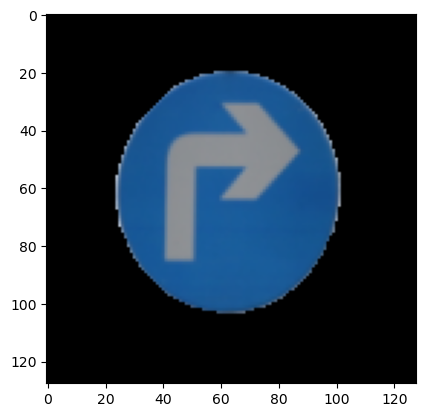

In [92]:
plt.imshow(test_img_ls[0])

In [79]:
error = []
for i, img in enumerate(test_img_ls):
    hist_features = np.zeros(shape=(3,255, 1))
    r_hist = cv2.calcHist([img], [0], None, [255], [1, 256])
    g_hist = cv2.calcHist([img], [1], None, [255], [1, 256])
    b_hist = cv2.calcHist([img], [2], None, [255], [1, 256])
    with warnings.catch_warnings(record=True) as w:
        r_hist, g_hist, b_hist = r_hist/r_hist.sum(), g_hist/g_hist.sum(), b_hist/b_hist.sum()
    if len(w) > 0:
        print(i)
        error.append(i)
for i in error:
    print(test_img_paths[i])

In [93]:
test_hist_features_ls = np.zeros(shape=(len(test_img_ls), 3, 255, 1))
test_canny = np.zeros(shape=(len(test_img_ls), 128, 128))
test_canny_features_ls = np.zeros(shape=(len(test_img_ls), 256))
test_hog_features_ls = np.zeros(shape=(len(test_img_ls), 34596))

for i, img in enumerate(test_img_ls):
    test_hist_features_ls[i] = calcAllHist(img)
    test_canny[i],test_canny_features_ls[i] = cannyFilter(img)
    test_hog_features_ls[i] = computeHOG(img)

In [94]:
X_test_hist_flattened = test_hist_features_ls.reshape(test_hist_features_ls.shape[0], -1)
X_test_canny_flattened = test_canny_features_ls.reshape(test_canny_features_ls.shape[0], -1)
X_test_hog_flattened = test_hog_features_ls

## Load and evaluate models

In [82]:
best_knn_hist = joblib.load("./models/best_knn_hist.pkl")
best_knn_canny = joblib.load("./models/best_knn_canny.pkl")
best_knn_hog = joblib.load("./models/best_knn_hog.pkl")
best_rf_hist = joblib.load("./models/best_rf_hist.pkl")
best_rf_canny = joblib.load("./models/best_rf_canny.pkl")
best_rf_hog = joblib.load("./models/best_rf_hog.pkl")

/home/tunguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning:

Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/tunguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/tunguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.3.0. T

In [83]:
classifiers = [
    best_knn_hist,
    best_rf_hist,
    best_knn_canny,
    best_rf_canny,
    best_knn_hog,
    best_rf_hog,
]

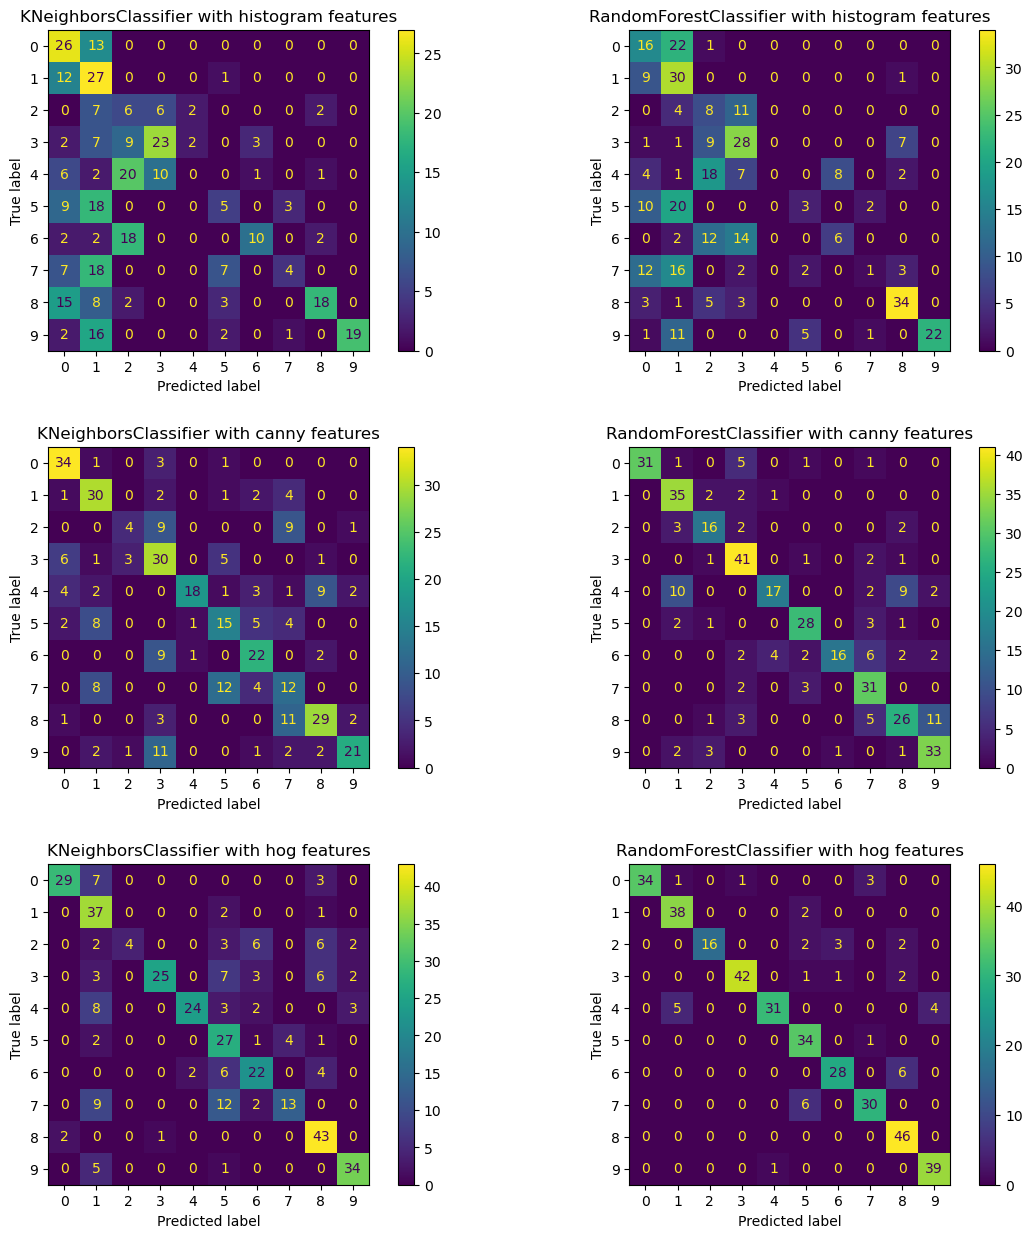

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.subplots_adjust(wspace=0, hspace=0.3)
for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):
    y_pred = clf.predict(X_test_hist_flattened if i < 2 else X_test_canny_flattened if i < 4 else X_test_hog_flattened)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_).plot(ax=ax)
    ax.title.set_text(type(clf).__name__ + " with" + (" histogram" if i < 2 else " canny" if i < 4 else " hog") + " features")
fig.savefig("./figs/confusion_matrices.png")

In [96]:
def modelScoring(clf, X, y):
    y_pred  = clf.predict(X)
    accuracy = round(accuracy_score(y, y_pred), 3)
    precision = round(precision_score(y, y_pred, average='macro', zero_division=0), 3)
    recall =  round(recall_score(y, y_pred, average='macro', zero_division=0), 3)
    f1 = round(f1_score(y, y_pred, average='macro', zero_division=0), 3)
    return accuracy, precision, recall, f1

In [97]:
acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
for i, clf in enumerate(classifiers):
    X_test = X_test_hist_flattened if i < 2 else X_test_canny_flattened if i < 4 else X_test_hog_flattened
    acc, precision, recall, f1  = modelScoring(clf, X_test, y_test)
    acc_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

In [98]:
models = ['knn_hist', 'rf_hist', 'knn_canny', 'rf_canny', 'knn_hog', 'rf_hog']
df = pd.DataFrame(data=[models, acc_scores, precision_scores, recall_scores, f1_scores], 
                  index=['model', 'acc', 'precision', 'recall', 'f1']).transpose()
df.head(6)

,model,acc,precision,recall,f1
0,knn_hist,0.364,0.452,0.352,0.342
1,rf_hist,0.391,0.385,0.37,0.333
2,knn_canny,0.567,0.592,0.546,0.546
3,rf_canny,0.723,0.749,0.72,0.715
4,knn_hog,0.681,0.765,0.655,0.65
5,rf_hog,0.892,0.905,0.881,0.886


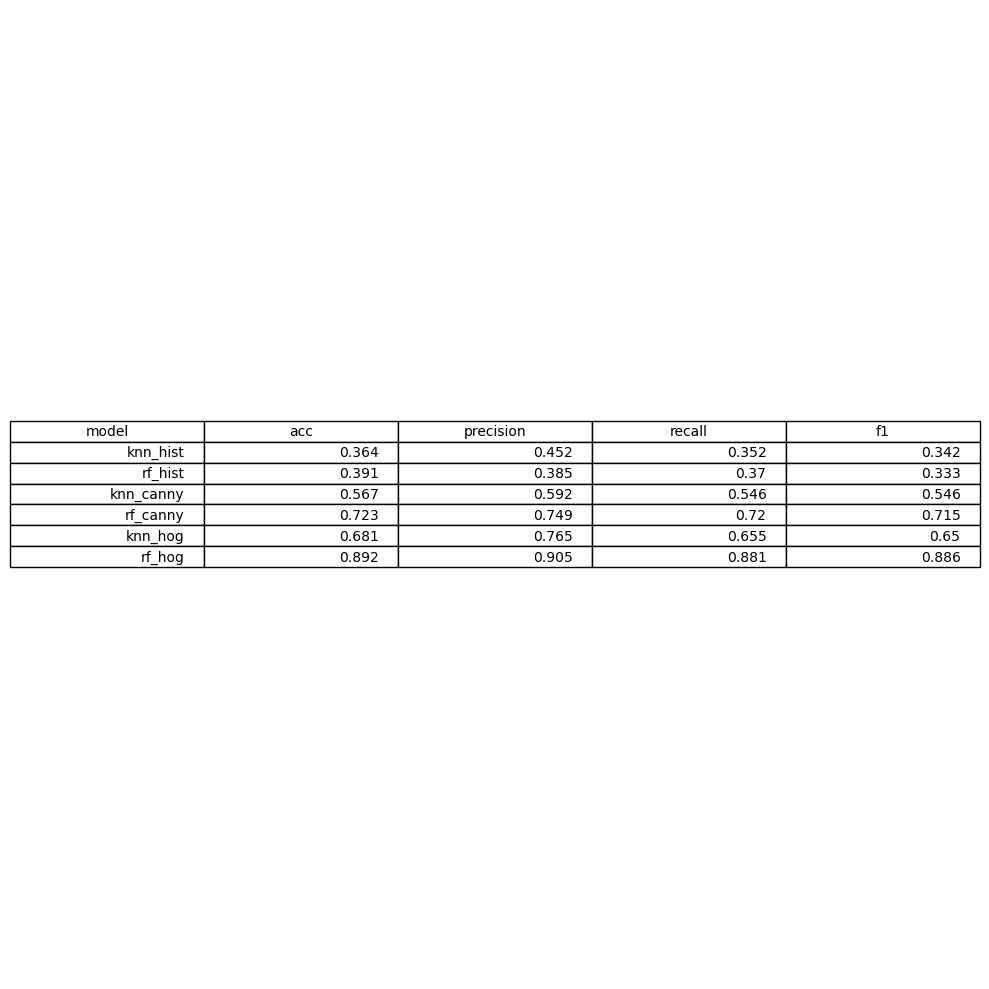

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()
fig.savefig("./figs/scores.png")

# Demo


In [100]:
best_model = joblib.load("./models/best_rf_hog.pkl")

/home/tunguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/tunguyen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [101]:
labels = pd.read_csv('./data/labels.csv')

In [102]:
def modelDemo():
    rand_index = random.randrange(0, len(test_img_ls))
    demo = test_img[rand_index]
    demo_img = graphSeg(demo,5,5,118,118)
    y_demo = y_test[rand_index]
    X_demo = computeHOG(demo_img).reshape(1, -1)
    y_pred_demo = best_model.predict(X_demo)
    pred_class_id, class_id = le.inverse_transform(y_pred_demo), le.inverse_transform([y_demo])
    pred_class = labels.loc[labels["ClassId"] == int(class_id[0]), "Name"].iloc[0]
    demo_class = labels.loc[labels["ClassId"] == int(class_id), "Name"].iloc[0]
    plt.imshow(demo)
    plt.axis('off')
    plt.title(f"Predicted label: {pred_class} \n True label: {demo_class}")

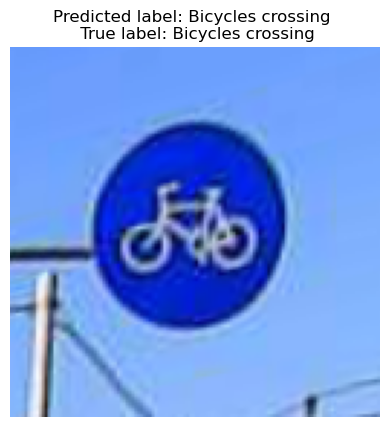

In [104]:
modelDemo()